In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from haversine import haversine
from sklearn.metrics import fbeta_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline
from common import load_clean_train, load_clean_test, load_midpoint_id, \
    extract_dates, add_midpoint_loc_id, tt_join_city_stats2clean, load_clean_parking,\
    add_yelp, add_parking_vecs, get_XY, premodel_formating2

In [2]:
train_df = load_clean_train()
test_df = load_clean_test()
print(train_df.shape, test_df.shape)

train_df = extract_dates(train_df)
simple = train_df.copy()
test_df = extract_dates(test_df)
simple_test = test_df.copy()
print(train_df.shape, test_df.shape)

train_df = add_midpoint_loc_id(train_df)
test_df = add_midpoint_loc_id(test_df)
print(train_df.shape, test_df.shape)

train_df = tt_join_city_stats2clean(train_df)
test_df = tt_join_city_stats2clean(test_df)
print(train_df.shape, test_df.shape)

train_df = add_yelp(train_df)
test_df = add_yelp(test_df)
print(train_df.shape, test_df.shape)

train_df = add_parking_vecs(train_df)
test_df = add_parking_vecs(test_df)
print(train_df.shape, test_df.shape)



(1100, 18) (726, 16)
(1100, 26) (726, 24)
(1100, 27) (726, 25)
(1100, 31) (726, 29)
(1100, 316) (726, 314)
(1100, 340) (726, 338)


In [3]:
tr, vl, ts, encodings = premodel_formating2(train_df, test_df)

In [4]:
X_tr, X_vl,y_tr, y_vl = get_XY(tr, vl)

In [5]:
X_tr.shape, y_tr.shape, X_vl.shape, y_vl.shape

((730, 327), (730,), (370, 327), (370,))

In [6]:
for col in X_tr.columns:
    print(col)

Clean_Street
Clean_From
Clean_To
lat_from
lng_from
lat_to
lng_to
lat_mid_x
lng_mid_x
holiday
day
mon
dow
week
hour
morn_night
loc_id
neighborhood
pop
area
med_age
max_rev_star_lvl1.0
max_rev_star_lvl1.5
max_rev_star_lvl2.0
max_rev_star_lvl2.5
max_rev_star_lvl3.0
max_rev_star_lvl3.5
max_rev_star_lvl4.0
max_rev_star_lvl4.5
max_rev_star_lvl5.0
mean_rev_star_lvl1.0
mean_rev_star_lvl1.5
mean_rev_star_lvl2.0
mean_rev_star_lvl2.5
mean_rev_star_lvl3.0
mean_rev_star_lvl3.5
mean_rev_star_lvl4.0
mean_rev_star_lvl4.5
mean_rev_star_lvl5.0
biz_ct_star_lvl1.0
biz_ct_star_lvl1.5
biz_ct_star_lvl2.0
biz_ct_star_lvl2.5
biz_ct_star_lvl3.0
biz_ct_star_lvl3.5
biz_ct_star_lvl4.0
biz_ct_star_lvl4.5
biz_ct_star_lvl5.0
ycat_acaibowls
ycat_accessories
ycat_active
ycat_adultedu
ycat_afghani
ycat_african
ycat_amateursportsteams
ycat_animalshelters
ycat_arabian
ycat_argentine
ycat_arts
ycat_asianfusion
ycat_austrian
ycat_bagels
ycat_bakeries
ycat_banks
ycat_bars
ycat_basque
ycat_bbq
ycat_beaches
ycat_beer_and_wine


In [7]:
m = xgb.XGBClassifier(max_depth=40,
                      learning_rate = 0.005,
                      n_estimators=2000,
                      verbose_eval=1,
                      reg_alpha=0.5,
                      reg_lambda=0.5,
                      colsample_bytree=0.3,
                      colsample_bylevel = 0.5,
                      n_jobs=-1)
gbm = m.fit(X_tr, y_tr, eval_set= [(X_tr, y_tr),(X_vl, y_vl)], early_stopping_rounds=100)

[0]	validation_0-error:0.179452	validation_1-error:0.359459
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.138356	validation_1-error:0.318919
[2]	validation_0-error:0.131507	validation_1-error:0.335135
[3]	validation_0-error:0.120548	validation_1-error:0.332432
[4]	validation_0-error:0.119178	validation_1-error:0.313514
[5]	validation_0-error:0.121918	validation_1-error:0.324324
[6]	validation_0-error:0.110959	validation_1-error:0.335135
[7]	validation_0-error:0.113699	validation_1-error:0.308108
[8]	validation_0-error:0.112329	validation_1-error:0.324324
[9]	validation_0-error:0.112329	validation_1-error:0.318919
[10]	validation_0-error:0.106849	validation_1-error:0.324324
[11]	validation_0-error:0.106849	validation_1-error:0.313514
[12]	validation_0-error:0.105479	validation_1-error:0.321622
[13]	validation_0-error:0.1	validation_1-error:0.308108

In [8]:
gbm.score(X_tr, y_tr)

0.91095890410958902

In [9]:
gbm.score(X_vl, y_vl)

0.69999999999999996

In [10]:
y_hat = m.predict(X_vl)
fbeta_score(y_vl, y_hat, beta=0.5)

0.51020408163265307

In [11]:
precision_score(y_hat, y_vl)

0.32258064516129031

In [12]:
recall_score(y_hat, y_vl)

0.59701492537313428

In [13]:
def plot_pred_coord(y_true, lat_true, lon_true, y_pred):
    """
    Should have ANY_SPOT, LAT, LON in both datasets
    """
    plot_mask1 = (y_hat == y_vl)
    plot_mask2 = (y_hat != y_vl) & (y_vl==0)
    plot_mask3 = (y_hat != y_vl) & (y_vl==1)
    
    plt.figure(figsize=(11,6))
    plt.scatter(lat_true[plot_mask1], lon_true[plot_mask1], c = 'g')
    plt.scatter(lat_true[plot_mask2], lon_true[plot_mask2], c = 'r')
    plt.scatter(lat_true[plot_mask3], lon_true[plot_mask3], c = 'b')

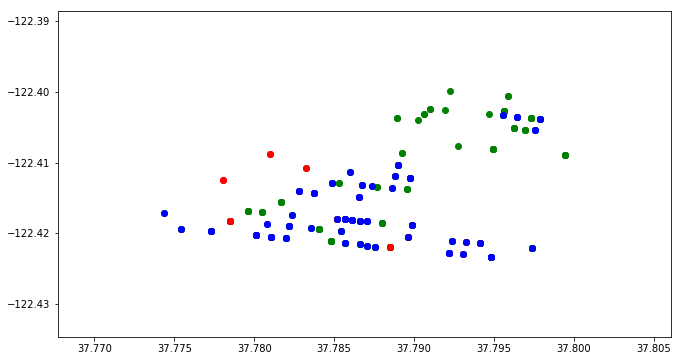

In [14]:
plot_pred_coord(y_hat, X_vl['lat_from'].values, X_vl['lng_from'].values , y_vl)

### Submission

In [15]:
tst_pred = m.predict(ts)
to_sub = pd.DataFrame({'id': range(1, len(tst_pred)+1), 'any_spot': tst_pred})

In [16]:
to_sub[['id','any_spot']].to_csv('submissions/w_yelp_sensor.csv', index=False)
to_sub.shape

(726, 2)

In [17]:
y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0,

In [18]:
rev_nh = {v:k for k,v in encodings['neighborhood'].items()}

In [19]:
X_vl.shape, sum(y_vl != y_hat)

((370, 327), 111)

In [61]:
train_df[train_df['loc_id']==19][['Clean_Street','Clean_From','Clean_To','lat_mid_y','lng_mid_y']]

,Clean_Street,Clean_From,Clean_To,lat_mid_y,lng_mid_y
186,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
187,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
200,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
201,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
219,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
250,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
282,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
283,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
295,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553
318,Van Ness Avenue,Golden Gate Avenue,Turk Street,37.781504,-122.420553


In [39]:
mortem = X_vl[y_vl != y_hat].copy()
mortem['neighborhood'] = mortem['neighborhood'].map(rev_nh)
mortem['neighborhood'].value_counts()

tenderloin           34
nobhill              18
fillmoredistrict     14
polkgulch            10
civiccenter           9
pacificheights        9
financialdistrict     8
lowernobhill          7
southofmarket         5
westernaddition       3
russianhill           1
Name: neighborhood, dtype: int64

In [63]:
train_df[train_df['loc_id']==19].sort_values(by='hour')

,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,Clean_Street,Clean_From,...,dowvec2,dowvec3,dowvec4,dowvec5,dowvec6,dowvec7,dowvec8,dowvec9,dowvec10,dowvec11
418,Van Ness Avenue,Golden Gate Avenue,Van Ness Avenue,2014-02-12,7:35,0,63.262000,0,Van Ness Avenue,Golden Gate Avenue,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675349,0.00000,0.000000,0.000000,0.000000
440,Van Ness Avenue,Golden Gate Avenue,Van Ness Avenue,2014-02-15,7:55,2,63.262000,1,Van Ness Avenue,Golden Gate Avenue,...,0.567536,0.000000,0.000000,0.412659,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
432,Van Ness Avenue,Van Ness Avenue,Turk Street,2014-02-15,7:54,0,52.836143,0,Van Ness Avenue,Golden Gate Avenue,...,0.567536,0.000000,0.000000,0.412659,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
282,Van Ness Avenue,Van Ness Avenue,Turk Street,2014-02-05,7:49,0,52.836143,0,Van Ness Avenue,Golden Gate Avenue,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675349,0.00000,0.000000,0.000000,0.000000
318,Van Ness Avenue,Van Ness Avenue,Turk Street,2014-02-08,7:33,0,52.836143,0,Van Ness Avenue,Golden Gate Avenue,...,0.567536,0.000000,0.000000,0.412659,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
327,Van Ness Avenue,Golden Gate Avenue,Van Ness Avenue,2014-02-08,7:33,4,63.262000,1,Van Ness Avenue,Golden Gate Avenue,...,0.567536,0.000000,0.000000,0.412659,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
406,Van Ness Avenue,Van Ness Avenue,Turk Street,2014-02-12,7:34,0,52.836143,0,Van Ness Avenue,Golden Gate Avenue,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675349,0.00000,0.000000,0.000000,0.000000
441,Van Ness Avenue,Golden Gate Avenue,Van Ness Avenue,2014-02-15,9:34,0,63.262000,0,Van Ness Avenue,Golden Gate Avenue,...,0.567536,0.000000,0.000000,0.412659,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
283,Van Ness Avenue,Van Ness Avenue,Turk Street,2014-02-05,9:06,1,52.836143,1,Van Ness Avenue,Golden Gate Avenue,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675349,0.00000,0.000000,0.000000,0.000000
295,Van Ness Avenue,Golden Gate Avenue,Van Ness Avenue,2014-02-05,9:15,2,63.262000,1,Van Ness Avenue,Golden Gate Avenue,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675349,0.00000,0.000000,0.000000,0.000000


In [71]:
train_df.groupby(['hour','dow'])[['any_spot']].mean().reset_index().pivot(index='hour', columns='dow', values='any_spot')

dow,0,1,2,3,4,5,6
hour,,,,,,,
7,0.333333,0.250000,0.260870,NaN,NaN,0.409091,0.800000
8,0.500000,0.000000,0.000000,NaN,NaN,0.190476,0.800000
9,0.666667,0.250000,0.333333,NaN,NaN,0.380952,0.750000
10,0.200000,0.142857,0.000000,NaN,NaN,0.250000,0.200000
11,0.000000,0.142857,1.000000,NaN,NaN,NaN,0.277778
12,0.100000,0.307692,NaN,NaN,0.000000,0.375000,0.000000
13,0.368421,0.166667,0.000000,0.000000,0.615385,0.705882,1.000000
14,0.500000,0.454545,0.411765,0.083333,0.444444,0.562500,0.277778
15,0.500000,0.450000,0.400000,0.388889,0.600000,0.750000,0.600000


In [66]:
train_df[train_df['loc_id']==19].groupby(['hour','dow']).size().reset_index().pivot(index='hour', columns='dow', values=0)

dow,0,2,4,5,6
hour,,,,,
7,NaN,3.0,NaN,4.0,NaN
9,NaN,2.0,NaN,1.0,NaN
11,NaN,NaN,NaN,NaN,2.0
14,NaN,NaN,NaN,NaN,4.0
16,2.0,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,2.0,NaN
18,NaN,NaN,NaN,1.0,NaN
21,NaN,NaN,4.0,NaN,NaN


In [64]:
mortem = X_vl[y_vl != y_hat].copy()
mortem.groupby(['loc_id','Clean_Street','hour','dow']).size().reset_index().sort_values(0, ascending=False)

,loc_id,Clean_Street,hour,dow,0
23,19,2,21,4,3
24,20,1,21,4,2
44,34,3,14,5,2
21,19,2,17,5,2
66,49,2,21,4,2
48,35,15,15,5,2
17,16,2,17,5,2
106,91,21,15,1,2
25,21,2,21,4,2
76,61,4,21,4,2


In [21]:
mortem = X_vl[y_vl != y_hat].copy()
mortem['hour'].value_counts()

21    20
15    19
14    17
18    10
16    10
13     9
20     8
17     7
12     5
19     4
22     2
Name: hour, dtype: int64

### Feature importance

In [22]:
cols = X_vl.columns
imp = m.feature_importances_

imp_df = pd.DataFrame({'field':cols, 'imp': imp}).sort_values('imp', ascending=False)
imp_cols = imp_df[imp_df['imp'] > 0.0005]['field'].values

In [23]:
imp_df[:20]

,field,imp
306,hourvec3,0.031696
303,hourvec0,0.029786
305,hourvec2,0.029404
315,dowvec0,0.028259
14,hour,0.027113
307,hourvec4,0.025967
311,hourvec8,0.025840
313,hourvec10,0.024949
10,day,0.024058
318,dowvec3,0.023676


In [24]:
imp_cols

array(['hourvec3', 'hourvec0', 'hourvec2', 'dowvec0', 'hour', 'hourvec4',
       'hourvec8', 'hourvec10', 'day', 'dowvec3', 'dowvec1', 'hourvec5',
       'dowvec7', 'hourvec7', 'hourvec9', 'hourvec1', 'hourvec11', 'week',
       'dowvec4', 'dowvec2', 'dowvec6', 'dowvec9', 'dowvec5', 'hourvec6',
       'dowvec8', 'dowvec10', 'dow', 'dowvec11', 'Clean_From', 'lat_from',
       'lat_mid_x', 'mean_rev_star_lvl3.5', 'lng_mid_x', 'morn_night',
       'mon', 'lng_from', 'lng_to', 'mean_rev_star_lvl4.5', 'loc_id',
       'mean_rev_star_lvl5.0', 'Clean_To', 'mean_rev_star_lvl2.5',
       'biz_ct_star_lvl3.5', 'Clean_Street', 'mean_rev_star_lvl2.0', 'pop',
       'biz_ct_star_lvl3.0', 'mean_rev_star_lvl4.0', '500-1000', 'med_age',
       'lat_to', 'ycat_bars', 'mean_rev_star_lvl3.0', 'biz_ct_star_lvl5.0',
       'ycat_playgrounds', '250-500', 'biz_ct_star_lvl2.5', 'ycat_delis',
       'neighborhood', 'ycat_japanese', 'area', 'max_rev_star_lvl5.0',
       'less_10', 'max_rev_star_lvl2.0', 'biz_ct

In [31]:
m = xgb.XGBClassifier(max_depth=6,
                      learning_rate = 0.005,
                      n_estimators=2000,
                      verbose_eval=1,
                      reg_alpha=0.25,
                      reg_lambda=0.25,
                      colsample_bytree=0.5,
                      colsample_bylevel = 0.5,
                      n_jobs=-1)
gbm = m.fit(X_tr[imp_cols], y_tr, eval_set= [(X_tr[imp_cols], y_tr),(X_vl[imp_cols], y_vl)], early_stopping_rounds=200)

[0]	validation_0-error:0.180822	validation_1-error:0.345946
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 200 rounds.
[1]	validation_0-error:0.178082	validation_1-error:0.313514
[2]	validation_0-error:0.176712	validation_1-error:0.332432
[3]	validation_0-error:0.175342	validation_1-error:0.313514
[4]	validation_0-error:0.165753	validation_1-error:0.318919
[5]	validation_0-error:0.158904	validation_1-error:0.305405
[6]	validation_0-error:0.150685	validation_1-error:0.302703
[7]	validation_0-error:0.150685	validation_1-error:0.302703
[8]	validation_0-error:0.156164	validation_1-error:0.297297
[9]	validation_0-error:0.156164	validation_1-error:0.286486
[10]	validation_0-error:0.149315	validation_1-error:0.3
[11]	validation_0-error:0.156164	validation_1-error:0.302703
[12]	validation_0-error:0.147945	validation_1-error:0.302703
[13]	validation_0-error:0.149315	validation_1-error:0.308108

[133]	validation_0-error:0.113699	validation_1-error:0.313514
[134]	validation_0-error:0.113699	validation_1-error:0.316216
[135]	validation_0-error:0.113699	validation_1-error:0.313514
[136]	validation_0-error:0.113699	validation_1-error:0.313514
[137]	validation_0-error:0.113699	validation_1-error:0.313514
[138]	validation_0-error:0.115068	validation_1-error:0.313514
[139]	validation_0-error:0.116438	validation_1-error:0.313514
[140]	validation_0-error:0.113699	validation_1-error:0.313514
[141]	validation_0-error:0.116438	validation_1-error:0.313514
[142]	validation_0-error:0.116438	validation_1-error:0.313514
[143]	validation_0-error:0.113699	validation_1-error:0.316216
[144]	validation_0-error:0.113699	validation_1-error:0.316216
[145]	validation_0-error:0.112329	validation_1-error:0.316216
[146]	validation_0-error:0.110959	validation_1-error:0.318919
[147]	validation_0-error:0.109589	validation_1-error:0.316216
[148]	validation_0-error:0.109589	validation_1-error:0.316216
[149]	va

In [32]:
gbm.score(X_tr[imp_cols], y_tr)

0.90273972602739727

In [33]:
gbm.score(X_vl[imp_cols], y_vl)

0.68108108108108112

In [34]:
y_hat = m.predict(X_vl[imp_cols])
fbeta_score(y_vl, y_hat, beta=0.5)

0.43674698795180728

In [35]:
precision_score(y_hat, y_vl)


0.23387096774193547

In [36]:
recall_score(y_hat, y_vl)


0.55769230769230771

In [37]:
tst_pred = m.predict(ts[imp_cols])
to_sub = pd.DataFrame({'id': range(1, len(tst_pred)+1), 'any_spot': tst_pred})
to_sub[['id','any_spot']].to_csv('submissions/w_yelp2_imp_cols_sensor.csv', index=False)
to_sub.shape

(726, 2)

### Why are we bad in the tenderloin

In [38]:
train_df[train_df['neighborhood'] == 'tenderloin']['loc_id']

1       27
8       34
80      34
210     27
212     26
213     26
214     28
216     38
228     20
230     35
241     32
242     34
244     15
245     36
255     23
256     23
261     18
262     18
263     24
265     25
266     37
270     22
276     30
279     38
292     36
300     18
301     18
322     20
334     24
368     25
        ..
988     28
996     20
1006    23
1023    18
1025    37
1041    27
1042    27
1043    27
1047    26
1048    26
1049    28
1050    28
1053    38
1064    20
1065    20
1066    20
1069    35
1077    32
1078    32
1079    32
1080    34
1081    34
1082    34
1084    15
1085    15
1086    15
1087    36
1088    17
1098    23
1099    23
Name: loc_id, Length: 159, dtype: int64